## Read in the data and take care of it

In [6]:
import json

DATAPATH = "data/articles.json"

with open(DATAPATH, "r", encoding="utf-8") as f:
    articles = json.load(f)
    
all_categories = []
articles_dict = dict()
for article in articles:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())
#n_letters = 257 # the first 256 ASCII characters + a "bin" for weird characters

## Turning abstracts into pytorch tensors

In [23]:
import torch
import string
import unicodedata

n_letters = len(string.printable)+1
n_hidden = n_letters

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("€"))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])


## Creating the RNN architecture

In [24]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden , (h_t, c_t) = self.i2h(input)
        output = self.h2o(hidden[-1])
        output = self.softmax(output)
        return output
    
rnn=LSTM(n_letters, n_hidden, n_categories)

In [25]:
inp = lineToTensor("Rodrigo is my name")
output = rnn(inp)
print(output)

tensor([[-2.1754, -2.1308, -2.0076, -2.0481, -2.0628, -2.1469, -2.0428, -2.0341]],
       grad_fn=<LogSoftmaxBackward>)


## Preparing for training

In [26]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here"))))

('Economics', 2)


In [27]:
from random import choice

def randomTrainingExample():
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

randomTrainingExample()

('Quantitative Finance',
 'We discuss some methods to quantitatively investigate the properties of\ncorrelation matrices. Correlation matrices play an important role in portfolio\noptimization and in several other quantitative descriptions of asset price\ndynamics in financial markets. Specifically, we discuss how to define and\nobtain hierarchical trees, correlation based trees and networks from a\ncorrelation matrix. The hierarchical clustering and other procedures performed\non the correlation matrix to detect statistically reliable aspects of the\ncorrelation matrix are seen as filtering procedures of the correlation matrix.\nWe also discuss a method to associate a hierarchically nested factor model to a\nhierarchical tree obtained from a correlation matrix. The information retained\nin filtering procedures and its stability with respect to statistical\nfluctuations is quantified by using the Kullback-Leibler distance.',
 tensor([6]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
  

## Training the network

In [42]:
import torch.optim as optim

learning_rate = 0.01

criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, abstract_tensor):
    optimizer.zero_grad()
    
    output = rnn(abstract_tensor)
            
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
        
    return output, loss.item()

In [43]:
import time

n_iters = 500
print_every = 100
plot_every = 10

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, it/n_iters*100, timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 20.0% (1.0m 24.550705671310425s) 2.333 / Electrical Engineering and Systems Science X Computer Science
200 40.0% (2.0m 52.55218529701233s) 1.844 / Quantitative Finance X Quantitative Biology
300 60.0% (4.0m 18.129560470581055s) 1.824 / Quantitative Finance V
400 80.0% (5.0m 48.88153338432312s) 1.812 / Statistics X Economics
500 100.0% (7.0m 14.825100183486938s) 2.323 / Computer Science X Quantitative Biology


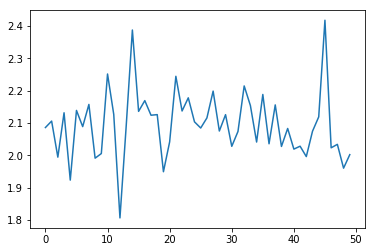

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)